In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


## For Loop first 6 experiments

In [4]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:6]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

experiment_names


['01_baseline',
 '02_pixel_composites',
 '03_seasonal_composites',
 '04_pixel_and_seasonal_comp',
 '05_support_fmask_dlt',
 '06_support_fmask_dlt_dem']

=== NEW EXPERIMENT ===
 --> Name: baseline
Train dataset valid pixel share: 	0.9901, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9918, count: 176


Epochs: 100%|██████████| 250/250 [03:32<00:00,  1.18it/s]

Results saved to: ../results/train/baseline


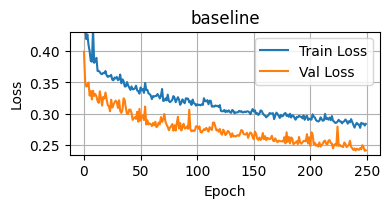

Minimum Validation Loss:  0.24103969064625827
DONE WITH  baseline
=== NEW EXPERIMENT ===
 --> Name: pixel_composites
Train dataset valid pixel share: 	0.9896, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9917, count: 176


Epochs: 100%|██████████| 250/250 [04:03<00:00,  1.03it/s]


Results saved to: ../results/train/pixel_composites


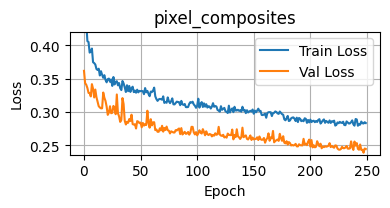

Minimum Validation Loss:  0.23897571726278824
DONE WITH  pixel_composites
=== NEW EXPERIMENT ===
 --> Name: seasonal_composites
Train dataset valid pixel share: 	0.9794, count: 728
Validation dataset valid pixel share: 	0.9809, count: 156
Test dataset valid pixel share: 	0.9716, count: 157


Epochs: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


Results saved to: ../results/train/seasonal_composites


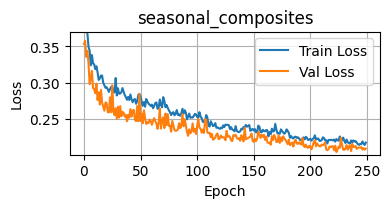

Minimum Validation Loss:  0.203791394447669
DONE WITH  seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: pixel_and_seasonal
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 250/250 [06:42<00:00,  1.61s/it]


Results saved to: ../results/train/pixel_and_seasonal


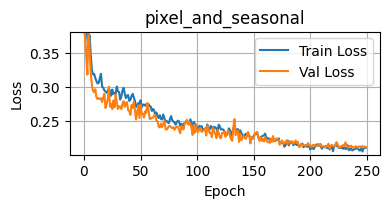

Minimum Validation Loss:  0.2098698188097049
DONE WITH  pixel_and_seasonal
=== NEW EXPERIMENT ===
 --> Name: all_aux_data
Train dataset valid pixel share: 	0.9740, count: 728
Validation dataset valid pixel share: 	0.9756, count: 156
Test dataset valid pixel share: 	0.9684, count: 157


Epochs: 100%|██████████| 250/250 [06:58<00:00,  1.67s/it]


Results saved to: ../results/train/all_aux_data


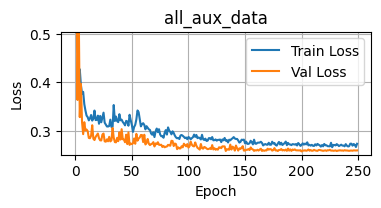

Minimum Validation Loss:  0.2568476605109679
DONE WITH  all_aux_data
=== NEW EXPERIMENT ===
 --> Name: mid_level_learning
Train dataset valid pixel share: 	0.9477, count: 846
Validation dataset valid pixel share: 	0.9596, count: 181
Test dataset valid pixel share: 	0.9511, count: 182


Epochs: 100%|██████████| 250/250 [09:20<00:00,  2.24s/it]


Results saved to: ../results/train/mid_level_learning


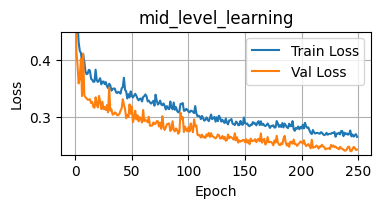

Minimum Validation Loss:  0.23955446193560712
DONE WITH  mid_level_learning


In [72]:
for exp_name in experiment_names:

    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    print("=== NEW EXPERIMENT ===")
    print(f" --> Name: {exp_name}")
    # Build dataset
    X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
    print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
    print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
    print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")

    
    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)

    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")



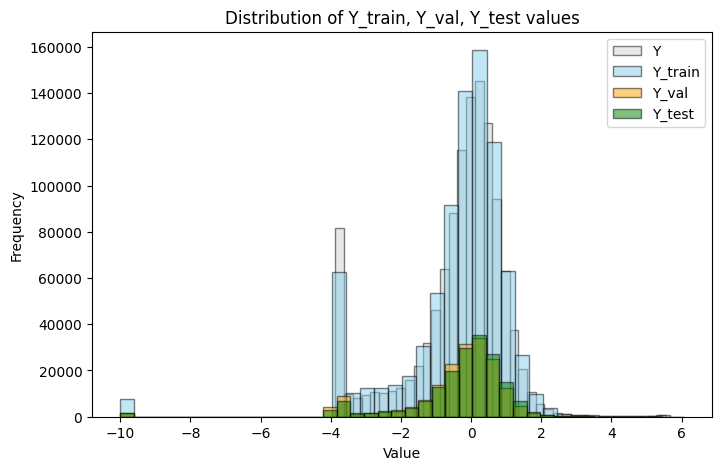

In [44]:
plt.figure(figsize=(8, 5))

plt.hist(Y.flatten(), bins=40, alpha=0.5, label='Y', color='lightgray', edgecolor='black')
plt.hist(Y_train.flatten(), bins=40, alpha=0.5, label='Y_train', color='skyblue', edgecolor='black')
plt.hist(Y_val.flatten(), bins=40, alpha=0.5, label='Y_val', color='orange', edgecolor='black')
plt.hist(Y_test.flatten(), bins=40, alpha=0.5, label='Y_test', color='green', edgecolor='black')

plt.title("Distribution of Y_train, Y_val, Y_test values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [91]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:7]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

In [92]:
experiment_names

['01_baseline',
 '02_pixel_composites',
 '03_seasonal_composites',
 '04_pixel_and_seasonal_comp',
 '05_support_fmask_dlt',
 '06_support_fmask_dlt_dem',
 '07_aux_task']

=== NEW EXPERIMENT ===
 --> Name: 01_baseline
Train dataset valid pixel share: 	0.9901, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9918, count: 176


Epochs: 100%|██████████| 300/300 [04:20<00:00,  1.15it/s]

Results saved to: ../results/train/01_baseline


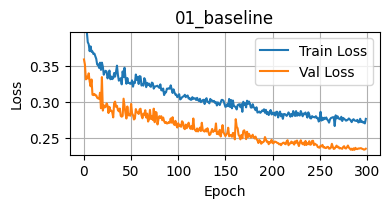

Minimum Validation Loss:  0.23335113308646463
DONE WITH  01_baseline
=== NEW EXPERIMENT ===
 --> Name: 02_pixel_composites
Train dataset valid pixel share: 	0.9896, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9917, count: 176


Epochs: 100%|██████████| 300/300 [08:46<00:00,  1.76s/it]


Results saved to: ../results/train/02_pixel_composites


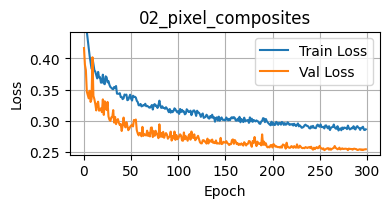

Minimum Validation Loss:  0.2527458830313249
DONE WITH  02_pixel_composites
=== NEW EXPERIMENT ===
 --> Name: 03_seasonal_composites
Train dataset valid pixel share: 	0.9794, count: 728
Validation dataset valid pixel share: 	0.9809, count: 156
Test dataset valid pixel share: 	0.9716, count: 157


Epochs: 100%|██████████| 300/300 [04:19<00:00,  1.15it/s]


Results saved to: ../results/train/03_seasonal_composites


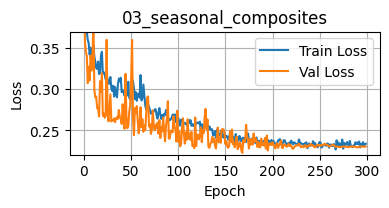

Minimum Validation Loss:  0.22244974092031136
DONE WITH  03_seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: 04_pixel_and_seasonal_comp
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 300/300 [08:20<00:00,  1.67s/it]


Results saved to: ../results/train/04_pixel_and_seasonal_comp


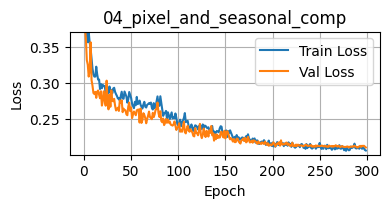

Minimum Validation Loss:  0.21060184484873062
DONE WITH  04_pixel_and_seasonal_comp
=== NEW EXPERIMENT ===
 --> Name: 05_support_fmask_dlt
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 300/300 [09:10<00:00,  1.84s/it]


Results saved to: ../results/train/05_support_fmask_dlt


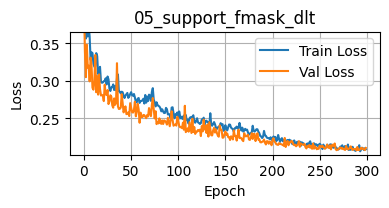

Minimum Validation Loss:  0.2074533448769496
DONE WITH  05_support_fmask_dlt
=== NEW EXPERIMENT ===
 --> Name: 06_support_fmask_dlt_dem
Train dataset valid pixel share: 	0.9740, count: 728
Validation dataset valid pixel share: 	0.9756, count: 156
Test dataset valid pixel share: 	0.9684, count: 157


Epochs: 100%|██████████| 300/300 [08:56<00:00,  1.79s/it]


Results saved to: ../results/train/06_support_fmask_dlt_dem


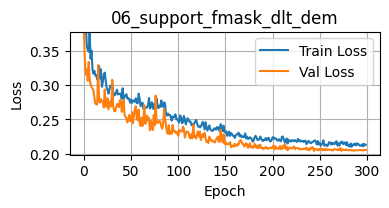

Minimum Validation Loss:  0.20391987378780657
DONE WITH  06_support_fmask_dlt_dem
=== NEW EXPERIMENT ===
 --> Name: 07_aux_task
Train dataset valid pixel share: 	0.9477, count: 846
Validation dataset valid pixel share: 	0.9596, count: 181
Test dataset valid pixel share: 	0.9511, count: 182


Epochs: 100%|██████████| 300/300 [11:03<00:00,  2.21s/it]


Results saved to: ../results/train/07_aux_task


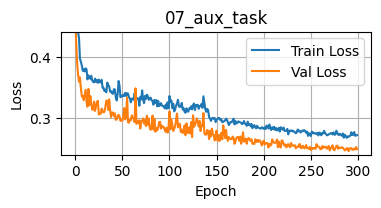

Minimum Validation Loss:  0.24563013486440669
DONE WITH  07_aux_task


In [93]:
for exp_name in experiment_names:
    
    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    print("=== NEW EXPERIMENT ===")
    print(f" --> Name: {exp_name}")
    # Build dataset
    X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
    print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
    print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
    print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")

    
    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)

    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")


## 250 again

In [118]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:7]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']
print(experiment_names)

['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


=== NEW EXPERIMENT ===
 --> Name: 01_baseline
Train dataset valid pixel share: 	0.9901, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9918, count: 176


Epochs: 100%|██████████| 250/250 [03:27<00:00,  1.21it/s]

Results saved to: ../results/train/01_baseline


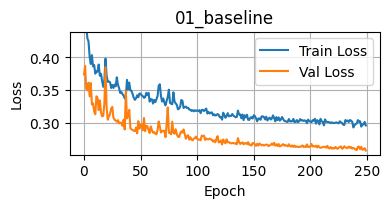

Minimum Validation Loss:  0.25763451104814356
DONE WITH  01_baseline
=== NEW EXPERIMENT ===
 --> Name: 02_pixel_composites
Train dataset valid pixel share: 	0.9896, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9917, count: 176


Epochs:  32%|███▏      | 80/250 [01:41<03:36,  1.27s/it]

Early stopping triggered at epoch 81
Results saved to: ../results/train/02_pixel_composites


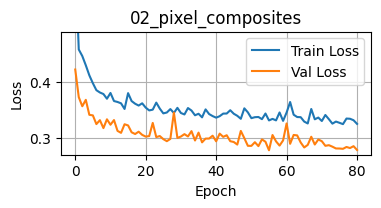

Minimum Validation Loss:  0.27776197411797265
DONE WITH  02_pixel_composites
=== NEW EXPERIMENT ===
 --> Name: 03_seasonal_composites
Train dataset valid pixel share: 	0.9794, count: 728
Validation dataset valid pixel share: 	0.9809, count: 156
Test dataset valid pixel share: 	0.9716, count: 157


Epochs: 100%|██████████| 250/250 [04:52<00:00,  1.17s/it]


Results saved to: ../results/train/03_seasonal_composites


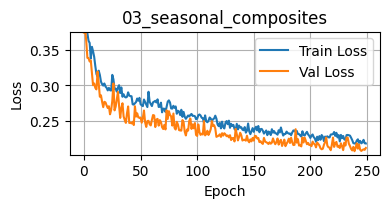

Minimum Validation Loss:  0.2065505706346952
DONE WITH  03_seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: 04_pixel_and_seasonal_comp
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 250/250 [05:50<00:00,  1.40s/it]


Results saved to: ../results/train/04_pixel_and_seasonal_comp


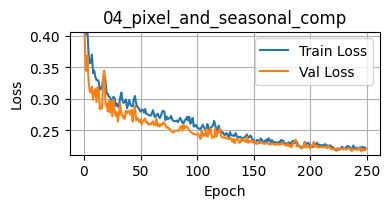

Minimum Validation Loss:  0.21640999271319464
DONE WITH  04_pixel_and_seasonal_comp
=== NEW EXPERIMENT ===
 --> Name: 05_support_fmask_dlt
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 250/250 [04:54<00:00,  1.18s/it]


Results saved to: ../results/train/05_support_fmask_dlt


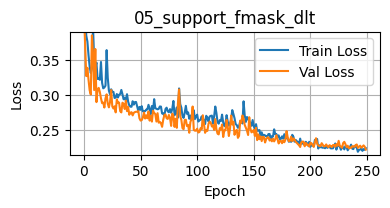

Minimum Validation Loss:  0.22136639860960153
DONE WITH  05_support_fmask_dlt
=== NEW EXPERIMENT ===
 --> Name: 06_support_fmask_dlt_dem
Train dataset valid pixel share: 	0.9740, count: 728
Validation dataset valid pixel share: 	0.9756, count: 156
Test dataset valid pixel share: 	0.9684, count: 157


Epochs: 100%|██████████| 250/250 [1:25:45<00:00, 20.58s/it]   


Results saved to: ../results/train/06_support_fmask_dlt_dem


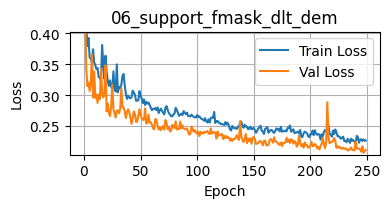

Minimum Validation Loss:  0.2069067393357937
DONE WITH  06_support_fmask_dlt_dem
=== NEW EXPERIMENT ===
 --> Name: 07_aux_task
Train dataset valid pixel share: 	0.9477, count: 846
Validation dataset valid pixel share: 	0.9596, count: 181
Test dataset valid pixel share: 	0.9511, count: 182


Epochs: 100%|██████████| 250/250 [06:09<00:00,  1.48s/it]


Results saved to: ../results/train/07_aux_task


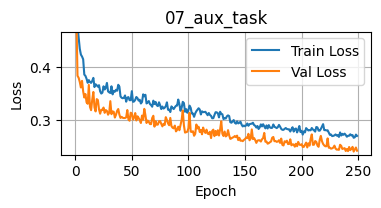

Minimum Validation Loss:  0.24098397379751363
DONE WITH  07_aux_task


In [ ]:
for exp_name in experiment_names:
    
    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    cfg.update(global_config)  # Ensure cfg has the latest global_config
    print("=== NEW EXPERIMENT ===")
    print(f" --> Name: {exp_name}")
    # Build dataset
    X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
    print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
    print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
    print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")

    
    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg, run_id=None)

    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")


## check data stack size

In [24]:
## datastack sizes 
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:7]  # Select the first 8 experiment names

dfnan2 = pd.DataFrame(columns=['Experiment', 'NanPercentAllowed', 'NumPatches', 'TotalPixels'])
for exp_name in experiment_names:
    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    cfg.update(global_config)  # Ensure cfg has the latest global_config
    print("=== EXPERIMENT ===")
    print(f" --> Name: {exp_name}")

    for nan_percent_allowed in [0, 4, 8, 12, 16, 20, 30, 40]:
        print(f"--- {exp_name}, nan pc: {nan_percent_allowed} ---")
        # Build dataset
        X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32, nan_percent_allowed=nan_percent_allowed)
        num_patches = len(X)
        total_pixels = num_patches * 32 * 32
        dfnan2 = pd.concat([dfnan2, pd.DataFrame([{'Experiment': exp_name, 
                             'NanPercentAllowed': nan_percent_allowed,
                             'NumPatches': num_patches,
                             'TotalPixels': total_pixels}])], ignore_index=True)
        print(f"Num patches: {num_patches}, Total pixels: {total_pixels}")
        #print(f"Data stack X shape: {X.shape}, Y shape: {Y.shape}")
    print("==========")

=== EXPERIMENT ===
 --> Name: 01_baseline
--- 01_baseline, nan pc: 0 ---
Site SITE1: extracted 358 patches.
Site SITE2: extracted 309 patches.
Site SITE3: extracted 106 patches.
Num patches: 773, Total pixels: 791552
--- 01_baseline, nan pc: 4 ---
Site SITE1: extracted 427 patches.
Site SITE2: extracted 369 patches.
Site SITE3: extracted 255 patches.
Num patches: 1051, Total pixels: 1076224
--- 01_baseline, nan pc: 8 ---
Site SITE1: extracted 440 patches.
Site SITE2: extracted 381 patches.
Site SITE3: extracted 348 patches.
Num patches: 1169, Total pixels: 1197056
--- 01_baseline, nan pc: 12 ---
Site SITE1: extracted 451 patches.
Site SITE2: extracted 393 patches.
Site SITE3: extracted 416 patches.
Num patches: 1260, Total pixels: 1290240
--- 01_baseline, nan pc: 16 ---
Site SITE1: extracted 458 patches.
Site SITE2: extracted 399 patches.
Site SITE3: extracted 485 patches.
Num patches: 1342, Total pixels: 1374208
--- 01_baseline, nan pc: 20 ---
Site SITE1: extracted 461 patches.
Site S

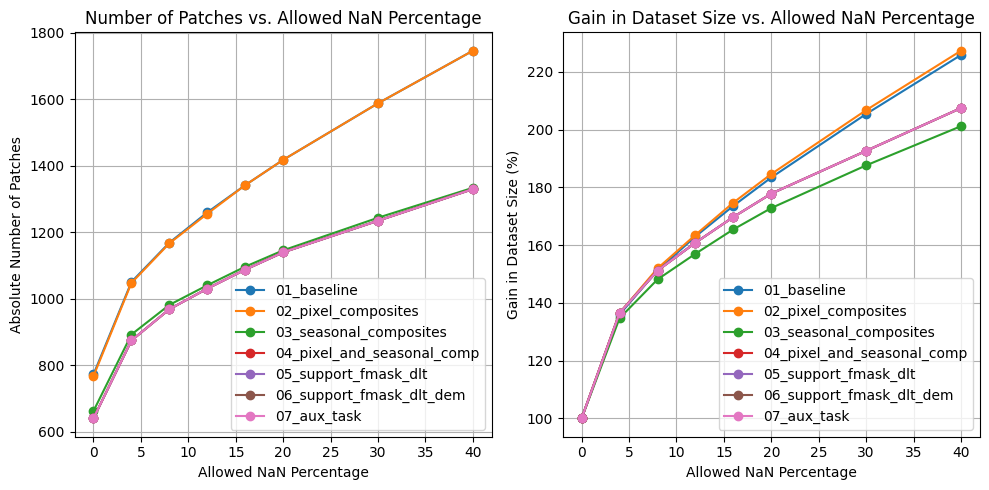

In [25]:
# plot the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Number of Patches vs. Allowed NaN Percentage
axes[0].set_title("Number of Patches vs. Allowed NaN Percentage")
for exp_name in experiment_names:
    if exp_name == "08_pretrained_encoder":  # Skip this experiment
        continue
    subset = dfnan2[dfnan2['Experiment'] == exp_name]
    axes[0].plot(subset['NanPercentAllowed'], subset['NumPatches'], marker='o', label=exp_name)

axes[0].set_xlabel("Allowed NaN Percentage")
axes[0].set_ylabel("Absolute Number of Patches")
axes[0].legend()
axes[0].grid()

# Plot Gain vs. Allowed NaN Percentage
axes[1].set_title("Gain in Dataset Size vs. Allowed NaN Percentage")
for exp_name in experiment_names:
    if exp_name == "08_pretrained_encoder":  # Skip this experiment
        continue
    subset = dfnan2[dfnan2['Experiment'] == exp_name]
    baseline_patches = int(subset[subset['NanPercentAllowed'] == 0]['NumPatches'].iloc[0])
    gain = subset['NumPatches'].astype(int) / baseline_patches * 100
    axes[1].plot(subset['NanPercentAllowed'], gain, marker='o', label=exp_name)

axes[1].set_xlabel("Allowed NaN Percentage")
axes[1].set_ylabel("Gain in Dataset Size (%)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

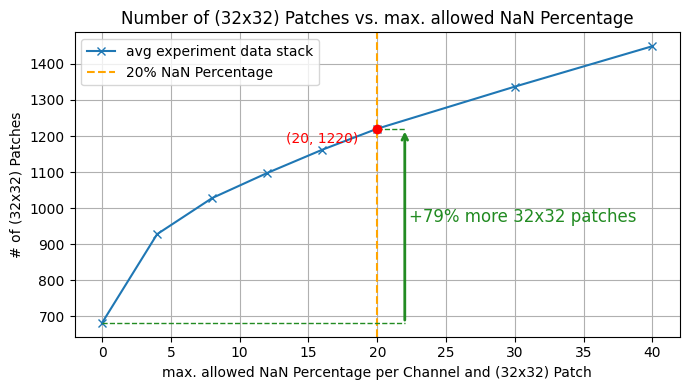

In [65]:
# Convert columns to numeric for calculations
dfnan2['NanPercentAllowed'] = pd.to_numeric(dfnan2['NanPercentAllowed'])
dfnan2['NumPatches'] = pd.to_numeric(dfnan2['NumPatches'])

# Calculate the average number of patches for each NanPercentAllowed
avg_patches = dfnan2.groupby('NanPercentAllowed')['NumPatches'].mean()

# Extract data for 20% NanPercentAllowed
nan_20_data = dfnan2[dfnan2['NanPercentAllowed'] == 20].groupby('NanPercentAllowed')['NumPatches'].mean()

# Plot the results
plt.figure(figsize=(7, 4))

# Plot the average line
plt.plot(avg_patches.index, avg_patches.values, label='avg experiment data stack', marker='x')

# Plot the line for 20% NanPercentAllowed
plt.axvline(x=20, color='orange', linestyle='--', label='20% NaN Percentage')

# Annotate the intersection point
intersection_x = 20
intersection_y = avg_patches.loc[20]
plt.scatter(intersection_x, intersection_y, color='red', zorder=5)
plt.annotate(f"({intersection_x}, {intersection_y:.0f})", 
             (intersection_x, intersection_y), 
             textcoords="offset points", 
             xytext=(-40, -10), 
             ha='center', 
             fontsize=10, 
             color='red')
# Annotate an arrow from 0% tolerance to 20% tolerance
start_x = 22
start_y = avg_patches.loc[0]
end_x = 22
end_y = avg_patches.loc[20]

plt.annotate(
    "", 
    xy=(end_x, end_y), 
    xytext=(start_x, start_y), 
    arrowprops=dict(arrowstyle="->", color="forestgreen", lw=2)
)

plt.plot([0, 22], [avg_patches.loc[0], avg_patches.loc[0]], linestyle="--", color="forestgreen", lw=1)
plt.plot([20, 22], [avg_patches.loc[20], avg_patches.loc[20]], linestyle="--", color="forestgreen", lw=1)
# Calculate the percentage increase
percentage_increase = ((end_y - start_y) / start_y) * 100

# Annotate the percentage increase
plt.text(
    (end_x+0.3), 
    (start_y + end_y) / 2, 
    f"+{percentage_increase:.0f}% more 32x32 patches", 
    color="forestgreen", 
    fontsize=12, 
    ha="left", 
    va="bottom"
)

# Add labels, legend, and title
plt.xlabel("max. allowed NaN Percentage per Channel and (32x32) Patch")
plt.ylabel("# of (32x32) Patches")
plt.title("Number of (32x32) Patches vs. max. allowed NaN Percentage")
plt.legend()
plt.grid()

plt.tight_layout()

# save figure 
output_folder = "../data/10_insights/patches/"
# create folder
os.makedirs(os.path.dirname(output_folder), exist_ok=True)
plt.savefig(f"{output_folder}patches_avg_vs_nan_percentage.png", dpi=300)
plt.savefig(f"{output_folder}patches_avg_vs_nan_percentage.pdf", dpi=300)
plt.show()

## main run of experiments

In [119]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[1:8]  # Select the first 6 experiment names
    # experiment_names = [#'01_baseline',
    #                     '02_pixel_composites',
    #                     '03_seasonal_composites',
    #                     #'04_pixel_and_seasonal_comp',
    #                     '05_support_fmask_dlt',
    #                     #'06_support_fmask_dlt_dem',
    #                     #'07_aux_task',
    #                     ]
    
with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']
#print(experiment_names)
experiment_names

['01_baseline',
 '02_pixel_composites',
 '03_seasonal_composites',
 '04_pixel_and_seasonal_comp',
 '05_support_fmask_dlt',
 '06_support_fmask_dlt_dem',
 '07_aux_task']

In [ ]:
import random

global_config = md.global_config
# reproducible shuffling (num_workers=0 -> simpler)
seed = global_config['seed']
run_id_base = "251028_PATCHTEST"
repetitions = 1


for i in range(repetitions): # Run 10 experiments with different seeds
    #run_id = md.generate_run_id()
    run_id = run_id_base + f"_{i}"
    seed = seed + i  # Different seed for each experiment
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    for exp_name in experiment_names:
        
        sites, cfg = cf.get_config(exp_name)  
        cfg.update(global_config)  # Ensure cfg has the latest global_config
        cfg.update({"seed": seed})
        #print("=== NEW EXPERIMENT ===")
        print(f" NEW: --> Name: {exp_name}, Run ID: {run_id}, Seed: {seed}")

        # Build dataset
        X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32, nan_percent_allowed=20)
        
        # split into train/val/test (70/15/15) with your logic
        (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y, seed=seed)

        # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
        train_dataset = md.S2CanopyHeightDataset(X_train, Y_train, cfg)
        val_dataset = md.S2CanopyHeightDataset(X_val, Y_val, cfg)
        test_dataset = md.S2CanopyHeightDataset(X_test, Y_test, cfg)

        train_loader = md.DataLoader(
            train_dataset,
            batch_size=global_config['batch_size'],
            shuffle=True,
            num_workers=0
        )
        val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
        test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
        
        if False:
            print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
            print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
            print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")
        
        # build model depending on in out channels, defined by the dataloaders
        model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0],cfg=cfg)
         
        #train model depending on config. 
        model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

        md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg, run_id=run_id)

        #eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
        #print("Minimum Validation Loss: ", min(logs['val_loss']))
        #print("DONE WITH ", exp_name)
        #print("=================")
    print("DONE WITH ALL EXPERIMENTS for iteration ", i)

 NEW: --> Name: 07_aux_task, Run ID: 251025_FINAL_0, Seed: 50


Epochs: 100%|██████████| 500/500 [09:15<00:00,  1.11s/it]


Evaluating on device: mps:0
Evaluating on device: mps:0
Results saved to: ../results/251025_FINAL_0/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  0
 NEW: --> Name: 07_aux_task, Run ID: 251025_FINAL_1, Seed: 51


Epochs: 100%|██████████| 500/500 [09:19<00:00,  1.12s/it]


Evaluating on device: mps:0
Evaluating on device: mps:0
Results saved to: ../results/251025_FINAL_1/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  1
 NEW: --> Name: 07_aux_task, Run ID: 251025_FINAL_2, Seed: 53


Epochs:  77%|███████▋  | 387/500 [07:11<02:06,  1.12s/it]

Early stopping triggered at epoch 388
Evaluating on device: mps:0
Evaluating on device: mps:0


Results saved to: ../results/251025_FINAL_2/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  2
 NEW: --> Name: 07_aux_task, Run ID: 251025_FINAL_3, Seed: 56


Epochs: 100%|██████████| 500/500 [09:17<00:00,  1.11s/it]


Evaluating on device: mps:0
Evaluating on device: mps:0
Results saved to: ../results/251025_FINAL_3/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  3
 NEW: --> Name: 07_aux_task, Run ID: 251025_FINAL_4, Seed: 60


Epochs:  99%|█████████▉| 497/500 [09:16<00:03,  1.12s/it]

Early stopping triggered at epoch 498
Evaluating on device: mps:0
Evaluating on device: mps:0


Results saved to: ../results/251025_FINAL_4/train/07_aux_task
DONE WITH ALL EXPERIMENTS for iteration  4


duration: 7 exp x 5 runs = 35 tasks 
233min = 233/60 = 3h50min 


In [109]:
# build dataframe with all channel-season-quantile combinations
seasons = ['spring', 'summer', 'autumn']
#seasons = ['summer']
quantiles = ['q1', 'q2', 'q3']
quantiles = ['q2']
channels = ['BLU','BNR','EVI','GRN','NBR','NDV','NIR','RE1','RE2','RE3','RED','SW1','SW2']

names = [f"{ch}_{season}_{q}" for season in seasons for ch in channels for q in quantiles]
df_test = pd.DataFrame({'Name': names})
df_test['season'] = df_test['Name'].apply(lambda x: x.split('_')[1])
df_test['quantile'] = df_test['Name'].apply(lambda x: x.split('_')[2])
df_test['channel'] = df_test['Name'].apply(lambda x: x.split('_')[0])
#df_test['idx'] = df_test.index  # index as a column (at the end)
# get indices for RED, GRN, BLU in summer q2 (robust to missing entries)
targets = ['RED', 'GRN', 'BLU']
indices = []
for ch in targets:
    idxs = df_test.loc[
        (df_test['season'] == 'summer') &
        (df_test['quantile'] == 'q2') &
        (df_test['channel'] == ch)
    ].index.tolist()
    indices.append(idxs[0] if idxs else None)

print("Indices for RED, GRN, BLU (season=summer, quantile=q2):", indices)

Indices for RED, GRN, BLU (season=summer, quantile=q2): [23, 16, 13]


In [ ]:
def get_rgb_indices(cfg):
    "return indices for RED, GRN, BLU in summer Q50"
    seasons = cfg['spectral'].get('seasons', [])
    quantiles = cfg['spectral'].get('quantiles', [])
    channels = ['BLU','BNR','EVI','GRN','NBR','NDV','NIR','RE1','RE2','RE3','RED','SW1','SW2']

    names = [f"{ch}_{season}_{q}" for season in seasons for ch in channels for q in quantiles]
    df = pd.DataFrame({'Name': names})
    df['season'] = df['Name'].apply(lambda x: x.split('_')[1])
    df['quantile'] = df['Name'].apply(lambda x: x.split('_')[2])
    df['channel'] = df['Name'].apply(lambda x: x.split('_')[0])

    targets = ['RED', 'GRN', 'BLU']
    indices = []
    for ch in targets:
        idxs = df.loc[
            (df['season'] == 'summer') &
            (df['quantile'] == 'Q50') &
            (df['channel'] == ch)
        ].index.tolist()
        indices.append(idxs[0] if idxs else None)

    return indices
#{'spectral': {'seasons': ['summer'], 'quantiles': ['Q25', 'Q50', 'Q75']},}

{'spectral': {'seasons': ['summer'], 'quantiles': ['Q25', 'Q50', 'Q75']}}

Transposing channels
(3, 32, 32)
Red min/max:  0.0 0.14486803
Green min/max:  0.0 0.31984127
Blue min/max:  0.0148131 0.1823863


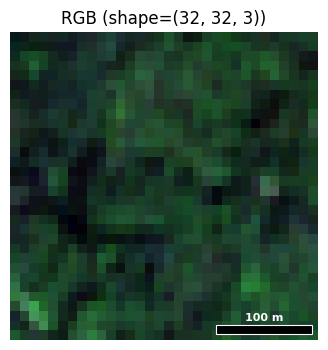

In [ ]:
import pandas as pd
# plot rgb (handles both HxWxC and CxHxW layouts and optional batch dim)
rgb = test_dataset.getRGB(10)

img = rgb.copy()

# if there's a batch dimension, take the first sample
if img.ndim == 4:
    img = img[0]

# channels-first (C,H,W) -> channels-last (H,W,C)
if img.ndim == 3 and img.shape[0] in (1, 3):
    print("Transposing channels")
    print(img.shape)
    img = np.transpose(img, (1, 2, 0))
    #print(img.shape)

img = img.astype(np.float32)
#img = np.clip(img, 0.0, 1.0)

print("Red min/max: ", img[:,:,0].min(), img[:,:,0].max())
print("Green min/max: ", img[:,:,1].min(), img[:,:,1].max())
print("Blue min/max: ", img[:,:,2].min(), img[:,:,2].max())

plt.figure(figsize=(4, 4))
brightness_factor = 2 # Adjust this factor to increase/decrease brightness
img = np.clip(img * brightness_factor, 0.0, 1.0)
plt.imshow(img.squeeze())

# add a scale bar (1 pixel == 10 m) in the bottom-right corner using axes-fraction coords
ax = plt.gca()
w = img.shape[1]
# fraction width corresponding to 10 pixels (10 px == 100 m)
bar_frac_w = 10.0 / w
bar_frac_h = 0.03  # bar height as fraction of axes
pad = 0.02  # padding from edges as fraction

bar_x = 1.0 - pad - bar_frac_w
bar_y = pad

rect = plt.Rectangle((bar_x, bar_y), bar_frac_w, bar_frac_h,
                     transform=ax.transAxes, facecolor='black',
                     edgecolor='white', linewidth=0.8, zorder=10)
ax.add_patch(rect)
ax.text(bar_x + bar_frac_w / 2, bar_y + bar_frac_h + 0.005,
        '100 m', transform=ax.transAxes,
        ha='center', va='bottom', color='white', fontsize=8, weight='bold', zorder=11)

plt.title(f"RGB (shape={img.shape})")
plt.axis('off')
plt.show()

In [12]:
from torchviz import make_dot

# Generate a simplified model graph for visualization
sample_input = torch.randn(1, 15, 32, 32).to(global_config['device'])  # Adjust input shape and device
output = model(sample_input)

# Create the graph, focusing on the main layers
model_graph = make_dot(output, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
model_graph.render("unet_architecture_simplified", format="png")  # Save as PNG


'unet_architecture_simplified.png'

In [37]:
from torchinfo import summary
from torch.nn import Conv2d, MaxPool2d, ConvTranspose2d

num_in = X[0].shape[0]
num_out = Y[0].shape[0]
output_bands = 3
print("Number of input bands: ", num_in)

#model = md.build_unet(in_channels=num_bands, out_channels=output_bands)
# Calculate the number of parameters and model depth
model_stats = summary(model, input_size=(1, num_in+1, global_config['patch_size'], global_config['patch_size']), device=global_config['device'])
print(model_stats)



# Function to calculate the receptive field
def calculate_receptive_field(model, input_size):
    """
    Calculate the receptive field of the model.
    """

    receptive_field = 1
    stride = 1
    padding = 0

    for layer in model.modules():
        if isinstance(layer, (Conv2d, MaxPool2d, ConvTranspose2d)):
            kernel_size = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size, layer.kernel_size)
            stride = layer.stride if isinstance(layer.stride, tuple) else (layer.stride, layer.stride)
            padding = layer.padding if isinstance(layer.padding, tuple) else (layer.padding, layer.padding)

            receptive_field = (receptive_field - 1) * stride[0] + kernel_size[0] - 2 * padding[0]

    return receptive_field

# Calculate the receptive field
receptive_field = calculate_receptive_field(model, input_size=(1, global_config['num_bands'], global_config['patch_size'], global_config['patch_size']))
print(f"Receptive Field: {receptive_field}")
# Check if the model uses BatchNorm layers
batchnorm_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.BatchNorm2d)]
if batchnorm_layers:
    print(f"The model uses {len(batchnorm_layers)} BatchNorm2d layers.")
    for i, layer in enumerate(batchnorm_layers, 1):
        print(f"BatchNorm Layer {i}: {layer}")
else:
    print("The model does not use any BatchNorm2d layers.")

    # Check if the model contains 1x1 convolutional layers
    conv1x1_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d) and layer.kernel_size == (1, 1)]
    if conv1x1_layers:
        print(f"The model contains {len(conv1x1_layers)} 1x1 Conv2d layers.")
        for i, layer in enumerate(conv1x1_layers, 1):
            print(f"1x1 Conv2d Layer {i}: {layer}")
    else:
        print("The model does not contain any 1x1 Conv2d layers.")

Number of input bands:  117
Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 32, 32]            --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           68,032
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Dropout2d: 2-3                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-5                         [1, 64, 32, 32]           --
│    └─Dropout2d: 2-6                    [1, 64, 32, 32]           --
├─MaxPool2d: 1-2                         [1, 64, 16, 16]           --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-7                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-8                         [1, 128, 16, 16]          --
│    └─Dropout2d: 2-9                    [1, 

In [57]:
#do i have mixed or fixed precision training enabled in default mps devide torch? print("Is MPS available: ", torch.backends.mps.is_available())
print("Is MPS built: ", torch.backends.mps.is_built())
print("Current device: ", torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
print("Is automatic mixed precision (AMP) enabled: ", torch.cuda.is_available() and torch.cuda.amp.is_available())

Is MPS built:  True
Current device:  mps
Is automatic mixed precision (AMP) enabled:  False


In [ ]:
pytorch_version = torch.__version__
print("PyTorch version: ", pytorch_version)


PyTorch version:  2.7.0
CUDA is not available on this system.


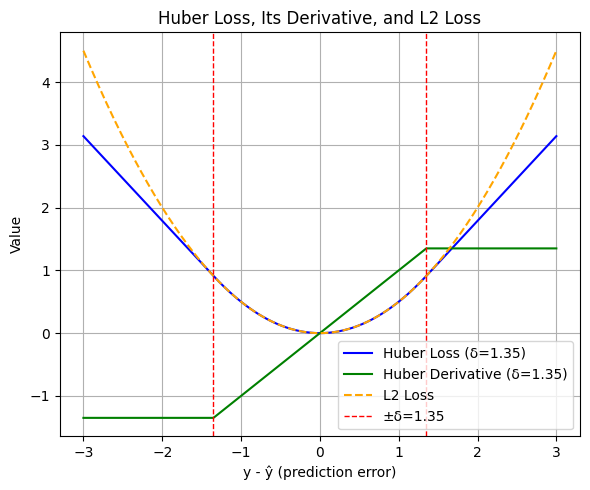

In [54]:

import numpy as np
import matplotlib.pyplot as plt

# Define the Huber loss function
def huber_loss(x, delta):
    return np.where(np.abs(x) <= delta, 0.5 * x**2, delta * (np.abs(x) - 0.5 * delta))

# Define the derivative of the Huber loss function
def huber_loss_derivative(x, delta):
    return np.where(np.abs(x) <= delta, x, delta * np.sign(x))

# Generate x values
x = np.linspace(-3, 3, 500)

# Calculate Huber loss and its derivative
delta = 1.35
loss = huber_loss(x, delta)
derivative = huber_loss_derivative(x, delta)

# Plot the Huber loss, its derivative, and L2 loss in one plot
plt.figure(figsize=(6, 5))

# Plot Huber loss
plt.plot(x, loss, label=f"Huber Loss (δ={delta})", color="blue")

# Plot Huber loss derivative
#plt.plot(x, loss, label=f"Huber Loss (δ={delta})", color="blue")
plt.plot(x, derivative, label=f"Huber Derivative (δ={delta})", color="green")

# Add L2 loss for reference
l2_loss = 0.5 * x**2
plt.plot(x, l2_loss, label="L2 Loss", color="orange", linestyle="--")

# Add vertical lines for ±δ
plt.axvline(x=-delta, color="red", linestyle="--", linewidth=1, label=f"±δ={delta}")
plt.axvline(x=delta, color="red", linestyle="--", linewidth=1)

# Add title, labels, legend, and grid
plt.title("Huber Loss, Its Derivative, and L2 Loss")
plt.xlabel("y - ŷ (prediction error)")
plt.ylabel("Value")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# individual tests, to be cleared

## 1st experiment: BASELINE

In [183]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("baseline")  
global_config = md.global_config

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

In [ ]:
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

In [146]:
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


In [148]:
md.save_results(model, logs, cfg)

Results saved to: ../results/train/baseline


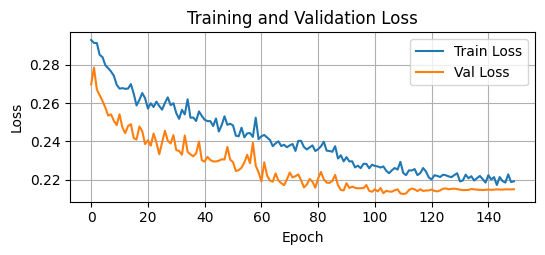

In [147]:
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])

## 2nd Experiment: + PIXEL COMPOSITES Q25, Q50, Q75

In [149]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


Results saved to: ../results/train/pixel_composites


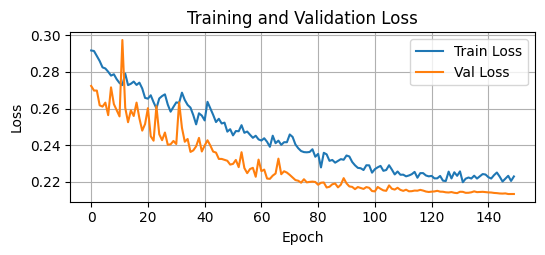

In [150]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])


In [151]:
print("Minimum Validation Loss: ", min(logs['val_loss']))

Minimum Validation Loss:  0.2132713171568784


In [152]:
X.shape

(1172, 40, 32, 32)

## 3rd experiment: seasonal_composites

In [153]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("seasonal_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


Results saved to: ../results/train/seasonal_composites


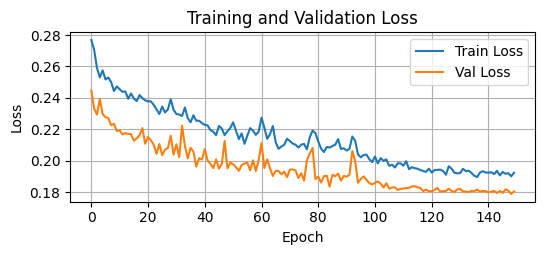

Minimum Validation Loss:  0.17872493618573898


In [ ]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 4th experiment: pixel_and_seasonal

In [155]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_and_seasonal")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


Results saved to: ../results/train/pixel_and_seasonal


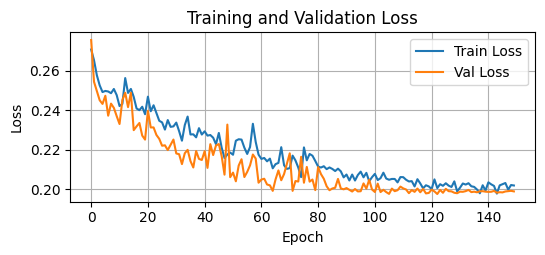

Minimum Validation Loss:  0.19751727198943114


In [156]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 5th experiment: pixel_and_seasonal + all aux

In [157]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("all_aux_data")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:40<00:00,  1.07s/it]


Results saved to: ../results/train/all_aux_data


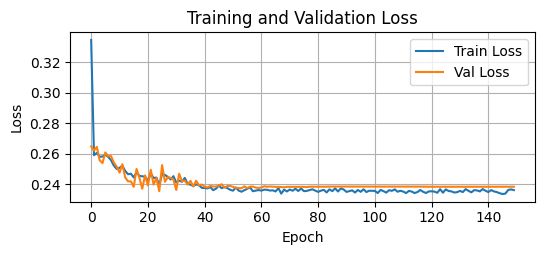

Minimum Validation Loss:  0.23547424108554155


In [158]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 6th experiment: Mid-Level-Learning

In [ ]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("mid_level_learning")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

In [ ]:
#model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


In [186]:
test_loader

Results saved to: ../results/train/baseline


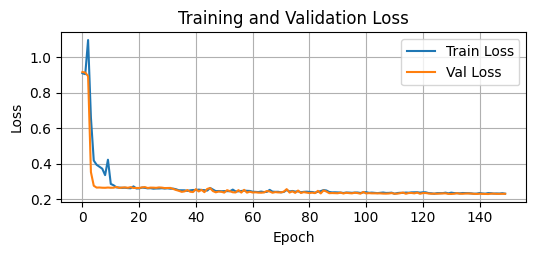

Minimum Validation Loss:  0.22883993050744456


In [197]:
md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

{'chm': {'_001': {'mu': 29.136810302734375, 'n': 424127, 'std': 5.059319972991943}, '_010': {'mu': 27.330501556396484, 'n': 331027, 'std': 6.319406986236572}, '_011': {'mu': 28.345002320026218, 'n': 755154, 'std': 5.611687865810269}, '_100': {'mu': 29.79595947265625, 'n': 753596, 'std': 9.429980278015137}, '_101': {'mu': 29.5585836550901, 'n': 1177723, 'std': 7.85599807406007}, '_110': {'mu': 29.043501579318452, 'n': 1084623, 'std': 8.480633136144107}, '_111': {'mu': 29.069731736028462, 'n': 1508750, 'std': 7.518862605606749}}, 'info': {'description': 'CHM normalization parameters', 'encoding': '001: FirstSite only, 010: Second Site, 100: Third Site', 'version': '1.0'}}


{'mu': 29.069731736028462, 'n': 1508750, 'std': 7.518862605606749}

In [181]:
test_np_array = np.random.rand(1, 15, 32, 32)
denormalized_array = md.denormalize_chm(test_np_array, normparams['chm']['_111'])

In [199]:
cfg['exp']

'baseline'

In [200]:
direc

'../results/train/baseline'

In [201]:
direc = os.path.join("../results/train", cfg['exp'])
preds_val, targets_val, preds_test, targets_test = md.load_np_stacks(cfg['exp'])

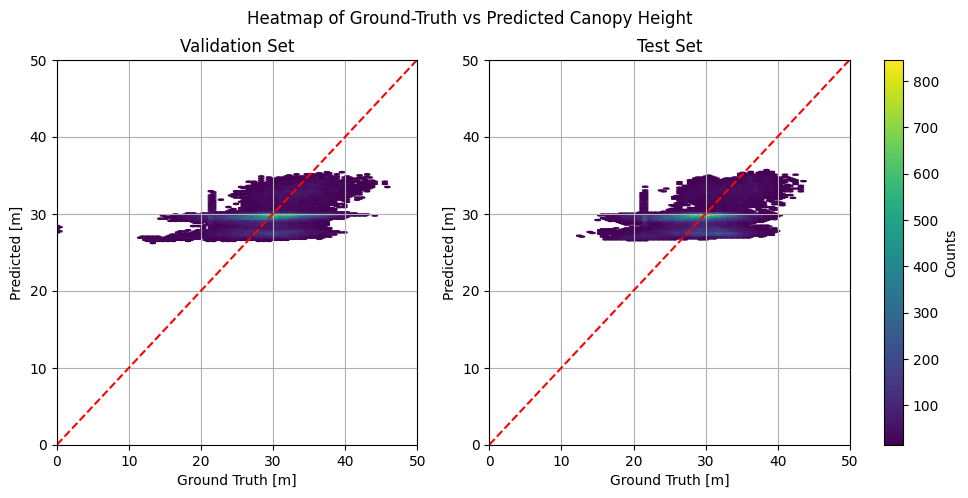

In [207]:
eval.plot_compact_heatmap_val_test(targets_val[:,0,:,:], preds_val[:,0,:,:], targets_test[:,0,:,:], preds_test[:,0,:,:], title="Heatmap of Ground-Truth vs Predicted Canopy Height\n")


In [206]:
preds_val[:,0,:,:]

array([[[29.228334, 29.195019, 29.318298, ..., 27.625126, 27.849678,
         28.368935],
        [29.231817, 29.20908 , 29.382376, ..., 26.858475, 27.1299  ,
         27.87675 ],
        [29.268469, 29.16478 , 29.35746 , ..., 26.605225, 26.798773,
         26.837229],
        ...,
        [28.213467, 27.70534 , 27.69547 , ..., 27.492243, 27.587065,
         27.685926],
        [28.322487, 27.850323, 27.838842, ..., 27.577091, 27.704319,
         27.079586],
        [28.692356, 28.366812, 27.742432, ..., 27.100689, 26.99114 ,
         26.250057]],

       [[30.783464, 30.952011, 30.785635, ..., 32.734894, 32.696148,
         32.065117],
        [31.00191 , 31.770645, 31.824152, ..., 32.94192 , 32.87419 ,
         31.767637],
        [31.321087, 32.02757 , 32.021038, ..., 32.955334, 33.128983,
         32.101448],
        ...,
        [32.383842, 33.035633, 33.60624 , ..., 30.142529, 30.254604,
         29.958284],
        [31.940338, 32.879642, 33.48127 , ..., 30.311537, 30.388004,
   